# Forests visualization data

## Python libraries

In [3]:
from shapely.geometry import shape, box
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import shapely.wkb 
from descartes import PolygonPatch
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np
from tqdm import tqdm
import os
import requests
import json
import ee

ee.Initialize()

## Utils
**cut_geom**

In [2]:
#### Brake shape up in pieces to get the data
def cut_geom(polygon, N):
    # Get bounds of grid
    lon_end,lat_start,lon_start,lat_end = polygon.bounds
   
    num_cells = N * N
    lon_edge = (lon_end - lon_start) / (num_cells ** 0.5)
    lat_edge = (lat_end - lat_start) / (num_cells ** 0.5)
    # Generate grid over feature
    polys = []
    lon = lon_start
    for i in range(0, N):
        x1 = lon
        x2 = lon + lon_edge
        lon += lon_edge
        lat = lat_start
        for j in range(0, N):
            y1 = lat
            y2 = lat + lat_edge
            lat += lat_edge
            polygon_temp = box(x1, y1, x2, y2)
            polys.append(polygon_temp)
    # Intersects grid against feature
    intersected_feats = []
    for p in polys:
        is_intersect = p.intersects(polygon)
        if is_intersect:
            intersection = p.intersection(polygon)
            intersected_feats.append(intersection)
    return intersected_feats

**merge_geometries**

In [3]:
def merge_geometries(df, column_name):
    df_new = pd.DataFrame(columns=list(df.columns))
    geom = []
    for value in tqdm(df[column_name].unique()):
        df_tmp = df[df[column_name] == value].iloc[:1]
        geom.append(cascaded_union(list(df[df[column_name] == value].geometry)))
        
        df_new = pd.concat([df_new, df_tmp])
        
    df_new.reset_index(inplace=True)
    df_new.drop(columns='index', inplace=True)
    df_new.drop(columns='geometry', inplace=True)
    df_new['geometry'] = geom

    return gpd.GeoDataFrame(df_new)

**df_from_carto**

In [70]:
def df_from_carto(account, query):
    """
    It gets data by querying a carto table and converts it into a GeoDataFrame.
    """
    urlCarto = f"https://{account}.carto.com/api/v2/sql"
    
    sql = {"q": query}
    r = requests.get(urlCarto, params=sql)
    
    data = r.json()
    
    df = gpd.GeoDataFrame(data.get("rows"))
    if 'the_geom' in df.columns:
        # Change geometry from WKB to WKT format
        df['geometry'] = df.apply(lambda x: shapely.wkb.loads(x['the_geom'],hex=True), axis=1 )
        df.drop(columns='the_geom', inplace=True)
        if 'the_geom_webmercator' in df.columns:
            df.drop(columns=['the_geom_webmercator'], inplace=True)
        df.crs = {'init': 'epsg:4326'}
        df = df.to_crs({'init': 'epsg:4326'})
        
    return df

## Amazon basin polygon

In [45]:
df = gpd.read_file('../data/Major_hydrological_basins/major_hydrobasins.shp')
df.columns = map(str.lower, df.columns)
df = df[df['maj_name'] == 'Amazon']
#Merge geometries
df = merge_geometries(df, 'maj_bas') 

100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


**Compute area in hectare**

In [46]:
df = df.set_crs(epsg=4326, allow_override=True)
df = df.to_crs("EPSG:4326")
df['area_ha'] = df['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)   
df

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,maj_bas,maj_name,maj_area,geometry,area_ha
0,3005,Amazon,5970775,"MULTIPOLYGON (((-51.23750 -0.42500, -51.25000 ...",5.970771e+08


**Simplify geometries**

In [47]:
#Simplify geometries
df['geometry'] = df['geometry'].apply(lambda x: x.simplify(0.1)) 

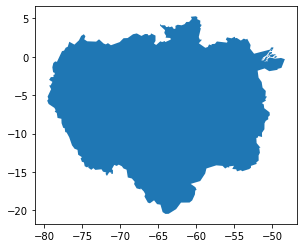

In [48]:
df.plot()

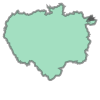

In [14]:
df['geometry'].iloc[0]
polygon = df['geometry'].iloc[0]
polygon

**Brake polygon in pieces**

In [15]:
polygons = cut_geom(polygon, 4)

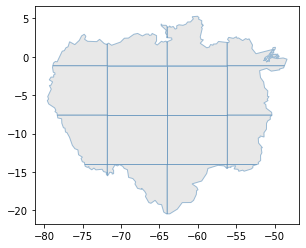

In [16]:
fig = plt.figure() 
ax = fig.gca() 
for i in range(len(polygons)):
    ax.add_patch(PolygonPatch(polygons[i], fc='lightgray', ec='steelblue', alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()

### USA states

In [83]:
account = 'wri-rw'

query =("SELECT the_geom, gid_0, name_0, name_1 FROM gadm36_1 WHERE gid_0='USA' and name_1 = 'California'")

df_usa = df_from_carto(account, query)

#Compute area in hectare
df_usa['area_ha'] = df_usa['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)  
df_usa  

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,gid_0,name_0,name_1,geometry,area_ha
0,USA,United States,California,"MULTIPOLYGON (((-118.58976 33.03865, -118.5897...",4.096173e+07


### Switzerland

In [103]:
account = 'wri-rw'

query =("SELECT the_geom, gid_0, name_0 FROM gadm36_0 WHERE name_0 = 'Switzerland'")

df_che = df_from_carto(account, query)

#Compute area in hectare
df_che['area_ha'] = df_che['geometry'].to_crs({'init': 'epsg:6933'}).map(lambda p: p.area / 10**4)  
df_che  

/Users/ikersanchez/anaconda3/envs/geoenv/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,gid_0,name_0,geometry,area_ha
0,CHE,Switzerland,"MULTIPOLYGON (((10.22766 46.61207, 10.22734 46...",4.124569e+06


## Hansen Global Forest Change v1.7 (2000-2019) data

In [17]:
## Tree cover loss by dominant driver - 2001-2019
loss_drivers = ee.Image('projects/wri-datalab/TSC_DRIVERS/2020/lossyear_classification')
print('Loss driver bands:', [b['id'] for b in loss_drivers.getInfo()['bands']])

## Tree cover - 2000
hansen = ee.Image("UMD/hansen/global_forest_change_2019_v1_7")

## Tree cover - 2010
treecover2010 = ee.Image("projects/wri-datalab/Treecover/treecover2010_30")

area = ee.Image.pixelArea()

scale = loss_drivers.projection().nominalScale().getInfo()
print('Scale:', scale) 

Loss driver bands: ['lossyear', 'class']
Scale: 27.829872698318393


### Compute tree cover loss time series

In [18]:
data = []
with open('../data/loss_data.json', 'w') as f:
    json.dump(data, f)
    
for y in range (1,20):
    print(f"Starting year: {2000+y}")
    loss_2019_binary = loss_drivers.select('lossyear').eq(y)
    
    try:

        with open('../data/loss_data.json') as f:
            data = json.load(f)
    
        loss_m2 = []
        for n, polygon in enumerate(tqdm(polygons)):
            feat_col = gpd.GeoSeries([polygon]).__geo_interface__
            basin = ee.FeatureCollection(feat_col)
    
            loss_m2.append(loss_2019_binary.multiply(area).reduceRegion(
                  reducer=ee.Reducer.sum(),
                  geometry=basin,
                  scale=scale,
                #   bestEffort=True,
                  maxPixels=1e18
                ).getInfo()['lossyear'])
        
        data += [{
            'loss_m2': sum(loss_m2),
            'year': 2000+y,
        }]
        
        with open('../data/loss_data.json', 'w') as f:
            json.dump(data, f)
    except:
        print(f"Year failed: {2000+y}")

  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2001


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2002


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2003


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2004


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2005


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2006


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2007


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2008


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2009


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2010


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2011


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2012


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2013


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2014


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2015


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2016


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2017


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2018


  0%|          | 0/16 [00:00<?, ?it/s]

Starting year: 2019


100%|██████████| 16/16 [03:19<00:00, 12.49s/it]


**Display data**

In [29]:
with open('../data/loss_data.json') as f:
    data = json.load(f)

In [30]:
print(f"From 2001 to 2019, Amazonas lost {round(sum(loss_m2)/1e10, 1)}Mha of tree cover.")

From 2001 to 2019, Amazonas lost 36.7Mha of tree cover.


Text(0, 0.5, '[Mha]')

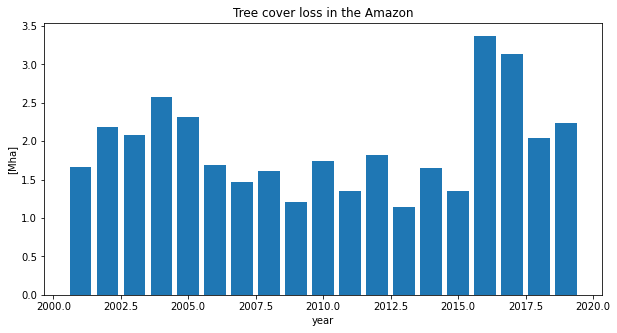

In [31]:
loss_m2 = list([d['loss_m2'] for d in data])
year = list([d['year'] for d in data])

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(year, np.array(loss_m2)/1e10)
ax.set_title('Tree cover loss in the Amazon')
ax.set_xlabel('year')
ax.set_ylabel('[Mha]')

### Compute tree cover loss by dominant driver (2000-2019)

In [22]:
class_dic = {'Commodity driven deforestation': 1,
            'Shifting agriculture': 2,
            'Forestry':3,
            'Wildfire': 4,
            'Urbanization':5,
            'Unknown': 0}

keys = list(class_dic .keys())
vals = list(class_dic .values())

In [23]:
## get class data
data = []
with open('../data/class_data.json', 'w') as f:
    json.dump(data, f)
        
for c in range (0,6):
    print(f"Starting class: {c}")
    all_loss_binary = loss_drivers.select('lossyear').neq(0)
    class_binary = loss_drivers.select('class').eq(c)
    
    masked = all_loss_binary.mask(class_binary)
    
    try:

        with open('../data/class_data.json') as f:
            data = json.load(f)
    
    
        loss_m2 = []
        for n, polygon in enumerate(tqdm(polygons)):
            feat_col = gpd.GeoSeries([polygon]).__geo_interface__
            basin = ee.FeatureCollection(feat_col)
            
            loss_m2.append(masked.multiply(area).reduceRegion(
                  reducer=ee.Reducer.sum(),
                  geometry=basin,
                  scale=scale,
                #   bestEffort=True,
                  maxPixels=1e18
                ).getInfo()['lossyear'])
            
        data += [{
            'loss_m2': sum(loss_m2),
            'class': keys[vals.index(c)],
        }]
        
        with open('../data/class_data.json', 'w') as f:
            json.dump(data, f)
    except:
        print(f"Class failed: {c}")

  0%|          | 0/16 [00:00<?, ?it/s]

Starting class: 0


  0%|          | 0/16 [00:00<?, ?it/s]

Starting class: 1


  0%|          | 0/16 [00:00<?, ?it/s]

Starting class: 2


  0%|          | 0/16 [00:00<?, ?it/s]

Starting class: 3


  0%|          | 0/16 [00:00<?, ?it/s]

Starting class: 4


  0%|          | 0/16 [00:00<?, ?it/s]

Starting class: 5


100%|██████████| 16/16 [03:16<00:00, 12.27s/it]


In [24]:
with open('../data/class_data.json') as f:
    data = json.load(f)

Text(0.5, 0, '[%]')

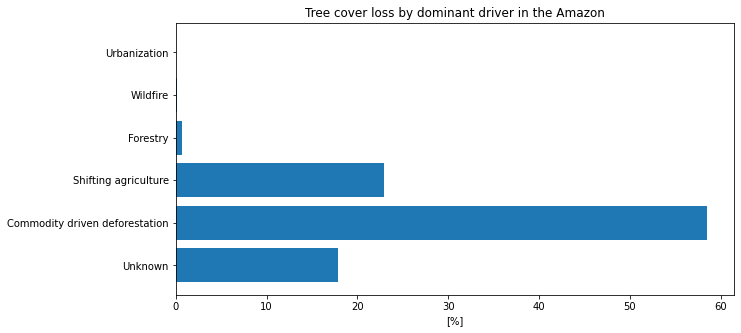

In [25]:
loss_m2 = list([d['loss_m2'] for d in data])
classes = list([d['class'] for d in data])

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(classes, np.array(loss_m2)*100/sum(loss_m2))
ax.set_title('Tree cover loss by dominant driver in the Amazon')
ax.set_xlabel('[%]')

### Compute tree cover in 2000 and 2010
**Tree cover in 2000  with > 30% canopy density**

In [61]:
thresh = 30 ###tree canopy cover threshold
treecover2000 = hansen.select('treecover2000').gte(thresh)


cover_m2 = []
for n, polygon in enumerate(tqdm(polygons)):
    feat_col = gpd.GeoSeries([polygon]).__geo_interface__
    basin = ee.FeatureCollection(feat_col)
    
    cover_m2.append(treecover2000.multiply(area).reduceRegion(
          reducer=ee.Reducer.sum(),
          geometry=basin,
          scale=scale,
        #   bestEffort=True,
          maxPixels=1e18
        ).getInfo()['treecover2000'])
    
cover_2000_m2 = sum(cover_m2)
print(f"2000 {round(cover_2000_m2/1e10, 1)} Mha  of tree cover in the Amazon")

100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

2000 513.8Mha  of tree cover in the Amazon


**Tree cover in 2010  with > 30% canopy density**

In [62]:
## get treecover2010 data
cover_m2 = []
for n, polygon in enumerate(tqdm(polygons)):
    feat_col = gpd.GeoSeries([polygon]).__geo_interface__
    basin = ee.FeatureCollection(feat_col)
    
    cover_m2.append(treecover2010.divide(255).multiply(area).reduceRegion(
          reducer=ee.Reducer.sum(),
          geometry=basin,
          scale=scale,
        #   bestEffort=True,
          maxPixels=1e18
        ).getInfo()['b1'])
    
cover_2010_m2  = sum(cover_m2)
print(f"2010 {round(cover_2010_m2/1e10, 1)} Mha  of tree cover in the Amazon")

100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

2010 503.8Mha  of tree cover in the Amazon


## All data

In [60]:
print(f"The Amazon basin covers {int(df['area_ha'].iloc[0]*1e-6)} Mha across nine countries and harbors 16,000 tree species." )

The Amazon basin covers 597Mha across nine countries and harbors 16,000 tree species.


In [159]:
print(f"The tiny trees here represent the estimated {round(cover_2000_m2/1e10)} Mha \
of tree cover present in the Amazon in the year 2000.\
That would be a tree cover area equivalent to {round((cover_2000_m2/1e4)/df_usa['area_ha'].iloc[0], 1)} Californias")

The tiny trees here represent the estimated 514 Mha of tree cover present in the Amazon in the year 2000.That would be a tree cover area equivalent to 12.5 Californias


In [160]:
print(f'2000 {round(cover_2000_m2/1e10, 1)} Mha of tree cover in the Amazon basin.')

2000 513.8 Mha of tree cover in the Amazon basin.


In [161]:
nTrees = 122
print(f"To get an idea of the scale, one tree represents {round((cover_2000_m2/1e10)/nTrees, 1)} ha of tree cover, equivalent to an area the size of {round(((cover_2000_m2/1e4)/nTrees)/df_che['area_ha'].iloc[0], 1)} Switzerland.")

To get an idea of the scale, one tree represents 4.2 ha of tree cover, equivalent to an area the size of 1.0 Switzerland.


In [128]:
with open('../data/loss_data.json') as f:
    data = json.load(f)
loss_m2 = list([d['loss_m2'] for d in data])
print(f"Let’s fast forward to 2019. This is how much of that 2000 tree cover is left. In these nineteen years, the Amazon has lost an area equivalent to the size of {round(sum(loss_m2)*1e-4/df_che['area_ha'].iloc[0])} Switzerlands since 2000.")

Let’s fast forward to 2019. This is how much of that 2000 tree cover is left. In these nineteen years, the Amazon has lost an area equivalent to the size of 9.0 Switzerlands since 2000.


In [162]:
print(f'2019 {round((cover_2000_m2 + ((cover_2010_m2-cover_2000_m2)/10)*19)*1e-10, 1)} Mha of tree cover in the Amazon basin.')

2019 494.9 Mha of tree cover in the Amazon basin.


In [158]:
with open('../data/class_data.json') as f:
    data = json.load(f)

loss_m2 = list([d['loss_m2'] for d in data])
classes = list([d['class'] for d in data])

print('But what have been the main drivers of deforestation in the Amazon in these 19 years?')

dic = []
for n, d in enumerate(data):
    print(f"{d['class']}: {round(list(np.array(loss_m2)*100/sum(loss_m2))[n], 2)} %")

But what have been the main drivers of deforestation in the Amazon in these 19 years?
Unknown: 17.86 %
Commodity driven deforestation: 58.53 %
Shifting agriculture: 22.88 %
Forestry: 0.63 %
Wildfire: 0.09 %
Urbanization: 0.01 %


## Carbon source/sink Figure
Data comes from [this paper](https://www.nature.com/articles/s41586-020-2035-0#Sec29) 

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
forests = pd.read_csv('../../../Earth_Dashboard/41586_2020_2035_MOESM9_ESM.csv')
forests.keys()

Index(['Unnamed: 0', 'year', 'Af_CarbonGains_mean', 'Af_CarbonLosses_mean',
       'Af_CarbonNetchange_mean', 'Af_CarbonGains_CI_low',
       'Af_CarbonLosses_CI_low', 'Af_CarbonNetchange_CI_low',
       'Af_CarbonGains_CI_upp', 'Af_CarbonLosses_CI_upp',
       'Af_CarbonNetchange_CI_upp', 'Am_CarbonGains_mean',
       'Am_CarbonLosses_mean', 'Am_CarbonNetchange_mean',
       'Am_CarbonGains_CI_low', 'Am_CarbonLosses_CI_low',
       'Am_CarbonNetchange_CI_low', 'Am_CarbonGains_CI_upp',
       'Am_CarbonLosses_CI_upp', 'Am_CarbonNetchange_CI_upp'],
      dtype='object')

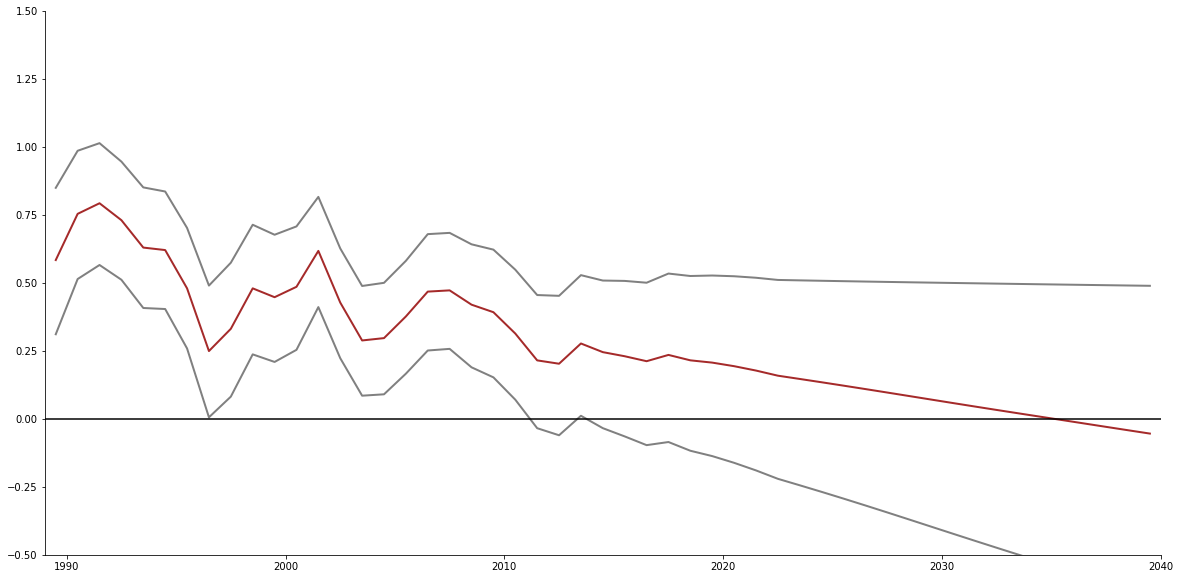

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))

#net carbon
ax.plot(forests.year,forests.Am_CarbonNetchange_mean,color='brown',linewidth=2)

#CI
ax.plot(forests.year,forests.Am_CarbonNetchange_CI_low,color='gray',linewidth=2)
ax.plot(forests.year,forests.Am_CarbonNetchange_CI_upp,color='gray',linewidth=2)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(1989,2040)
ax.set_ylim(-0.5,1.5)

ax.axhline(y=0,color='black')

plt.show()
fig.savefig(f'../../../Earth_Dashboard/amazon_sink_source.svg',dpi=300,transparent=True,format='svg')